In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
f = [f.name for f in fm.fontManager.ttflist]
plt.rc('font', family='Malgun Gothic')

In [2]:
path = '../Data/Preprocessed/topicResult_10_summary_tags.csv'
df_origin = pd.read_csv(path, encoding = 'cp949')
df_origin['date'] = pd.to_datetime(df_origin['date'])
df_origin['news_id'] = df_origin['news_id'].astype(str)
df_origin['propTopic'] = df_origin['propTopic'].astype(str)
df_origin['summary_tags'] = df_origin['summary_tags'].apply(lambda x : eval(x))
df_origin['keywords_tags'] = df_origin['keywords_tags'].apply(lambda x : eval(x))
df_origin['totalKeywords'] = df_origin['summary_tags'] + df_origin['keywords_tags']
df_origin.set_index('date', inplace = True)

innerOuter_path = '../Data/Preprocessed/innerOutTaged.csv'
innerOuter_origin = pd.read_csv(innerOuter_path)
innerOuter_origin['Timestamp'] = pd.to_datetime(innerOuter_origin['Timestamp'])
innerOuter_origin['news_id'] = innerOuter_origin['URL'].str.extract(r'news_id=(\d*)')
innerOuter_origin = innerOuter_origin.merge(df_origin[['news_id', 'propTopic']], on = ['news_id'], how = 'left')
innerOuter_origin = innerOuter_origin.loc[(innerOuter_origin['propTopic'].notnull())]
innerOuter_origin['propTopic'] = innerOuter_origin['propTopic'].astype(int)
innerOuter_origin.set_index('Timestamp', inplace = True)


C:\Users\WESLEYQUEST\AppData\Local\Temp\ipykernel_6244\1695347296.py:12: DtypeWarning: Columns (3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  innerOuter_origin = pd.read_csv(innerOuter_path)


In [13]:
df_origin.head(1)

,title,sub-title,publisher,author,date,text,keywords,href,numKeywords,news_id,...,day,summary,summary_tags,title_tags,subtitle_tags,keywords_tags,numTopic,propTopic,propTopicRatio,topicsRatio
0,2022년 올해의 정원식물은?,‘2022 대한민국 정원식물 전시·품평회’ 성료,라펜트,전지은,2022-11-07,‘2022 대한민국 정원식물 전시·품평회’를? 9월 30일부터 10월 30일까지 개...,"['한국수목원정원관리원', '대한민국 정원식물 전시·품평회', '정원식물']",https://www.lafent.com/inews/news_view.html?ne...,3,131470,...,7.0,한국수목원정원관리원은 가을 정취를 느낄 수 있는 FW 시즌 정원식물 788품종을 한...,"['한국', '수목원', '정원', '관리원', '가을', '정취', '느끼다', ...","['올해', '정원', '식물']","['대한민국', '정원', '식물', '전시', '품평회', '성']","['한국', '수목원', '정원', '관리원', '대한민국', '정원', '식물',...",10,8,0.701,"[(0, 0.12626038), (4, 0.07635856), (5, 0.08301..."


In [8]:
innerOuter_origin.head(1)

,Timestamp,IP,URL,URL Search Word,Referer,Referer Search Word,Referer Source,Referer Category,New IP,User Type,month,day,hour,bigPath,middlePath,smallPath,tmp,news_id,propTopic
6,2023-07-11 03:13:45+09:00,110.93.154.209,/inews/news_view_print.html?news_id=132561#,NaN,NaN,NaN,NaN,etc,1000200,내부,7,11,3,뉴스,뉴스홈,뉴스홈,inews,132561,2


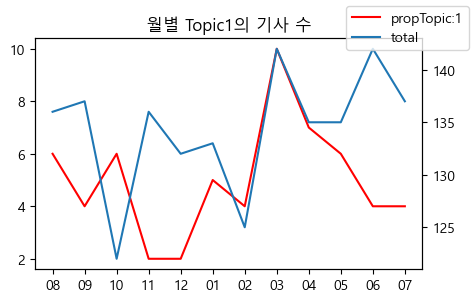

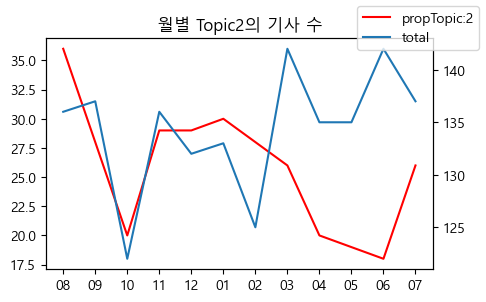

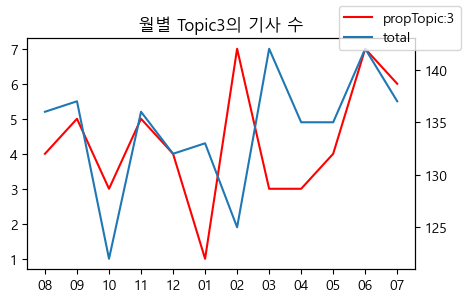

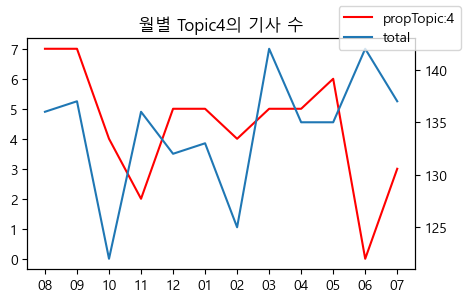

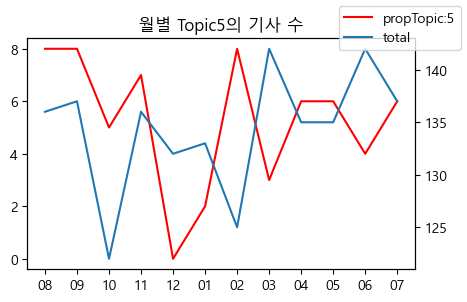

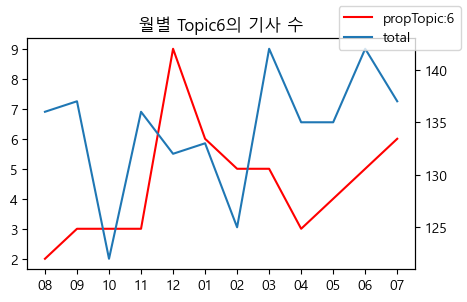

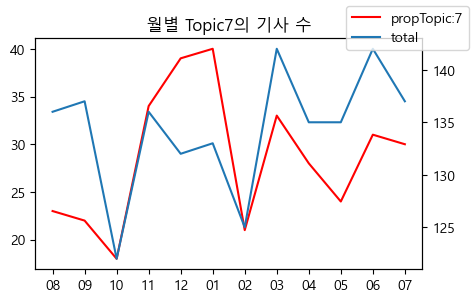

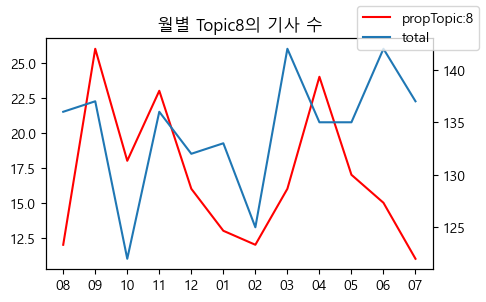

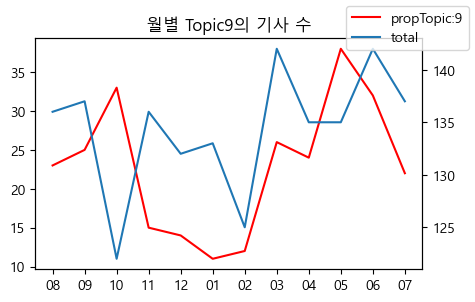

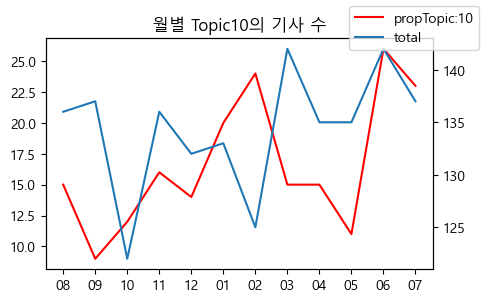

: 

In [84]:
# 월별 토픽별 작성 기사 수 
for propTopic in sorted(df_origin['propTopic'].unique().tolist()):
    fig, ax = plt.subplots(figsize = (5, 3))
    df = df_origin.copy()
    df = df.loc['2022/08':]
    tmp_total = df.resample('1M')['href'].count().reset_index()
    tmp = df.loc[df['propTopic'] == propTopic]
    tmp = tmp.resample('1M')['href'].count().reset_index()
    ax.plot(tmp['date'].astype(str).str[5:7], tmp['href'], color = 'r', label = f'propTopic:{int(propTopic) + 1}')
    ax_twin = ax.twinx()
    ax_twin.plot(tmp_total['date'].astype(str).str[5:7], tmp_total['href'], label = 'total')
    ax.set_title(f'월별 Topic{int(propTopic) + 1}의 기사 수')
    fig.legend()
    fig.savefig(f'../Result/Graph/PainPoint/numData_{int(propTopic) + 1}.png')  

    

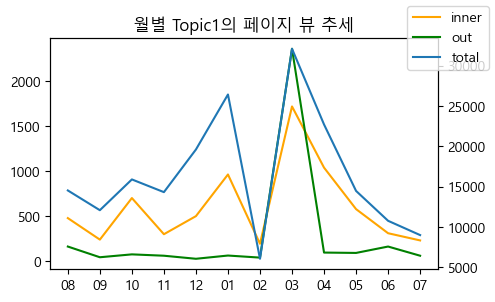

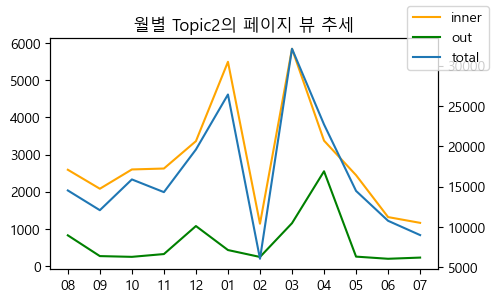

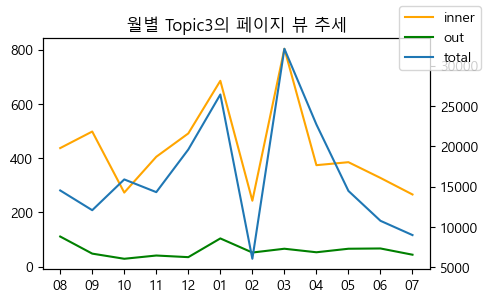

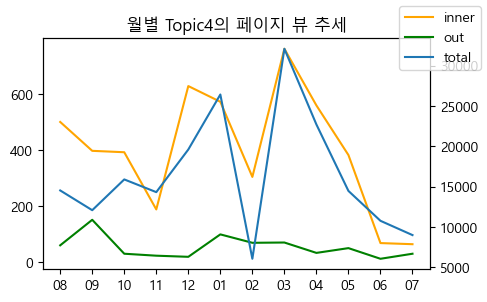

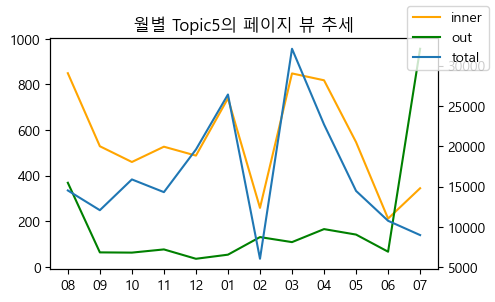

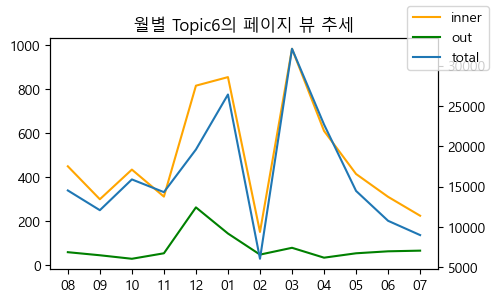

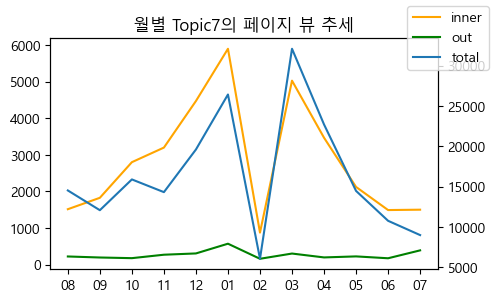

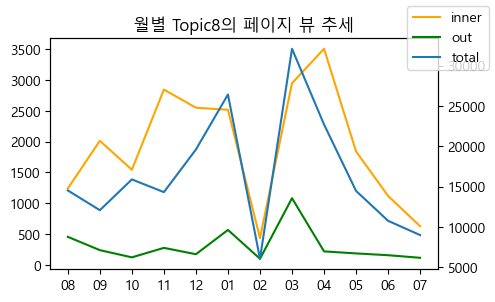

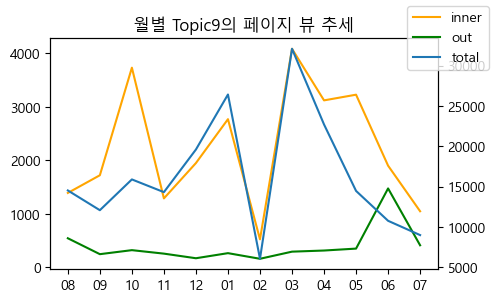

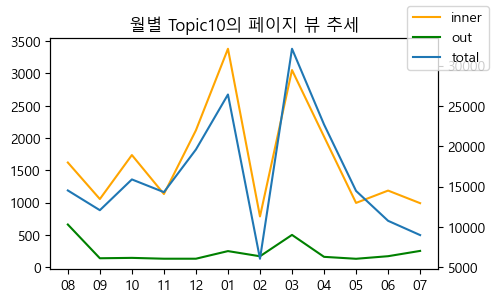

In [80]:
# 월별 토픽별 페이지 뷰 수 
for propTopic in sorted(innerOuter_origin['propTopic'].unique().tolist()):
    tmp = innerOuter_origin.loc[innerOuter_origin['propTopic'] == propTopic]
    tmp = tmp.groupby(['User Type']).resample('1M')['URL'].count().reset_index()

    fig, ax = plt.subplots(figsize = (5, 3))
    ax.plot(tmp.loc[(tmp['User Type'] == '내부'), 'Timestamp'].astype(str).str[5:7], tmp.loc[(tmp['User Type'] == '내부'), 'URL'], color = 'orange', label = 'inner')
    ax.plot(tmp.loc[(tmp['User Type'] == '외부'), 'Timestamp'].astype(str).str[5:7], tmp.loc[(tmp['User Type'] == '외부'), 'URL'], color = 'green', label = 'out')
       
    ax_twin = ax.twinx()
    tmp_total = innerOuter_origin.resample('1M')['URL'].count().reset_index()
    ax_twin.plot(tmp.loc[(tmp['User Type'] == '내부'), 'Timestamp'].astype(str).str[5:7], tmp_total['URL'], label = 'total')
    ax.set_title(f'월별 Topic{int(propTopic) + 1}의 페이지 뷰 추세')
    fig.legend()
    fig.savefig(f'../Result/Graph/PainPoint/pageView_{int(propTopic) + 1}.png')
    


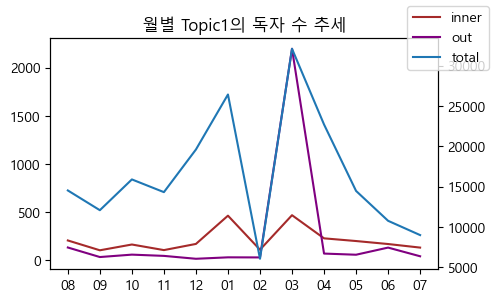

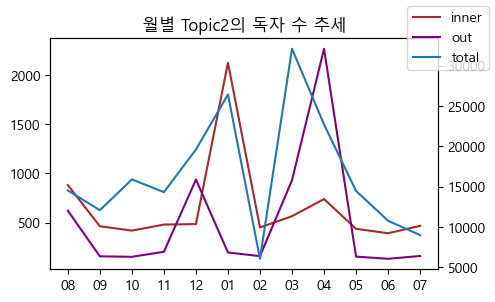

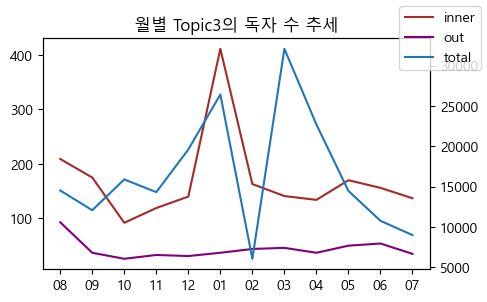

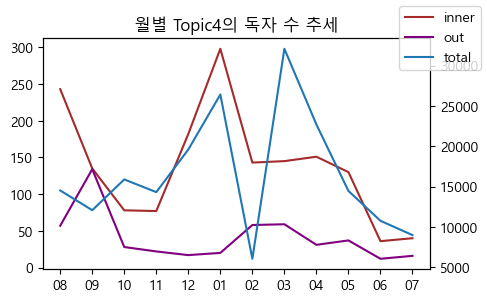

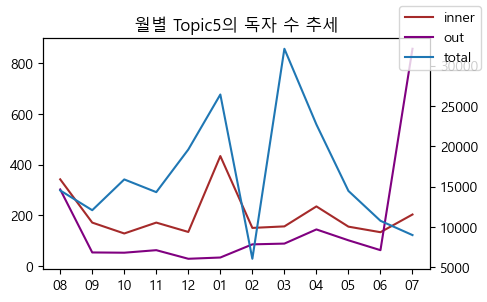

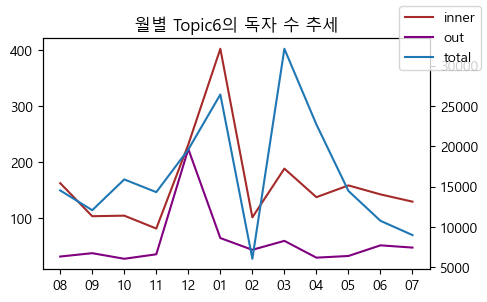

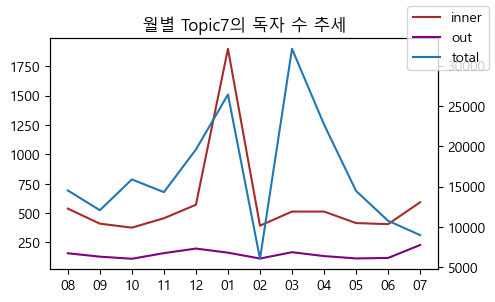

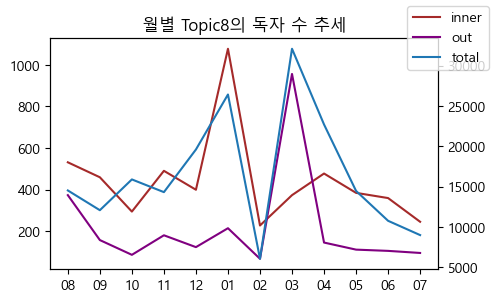

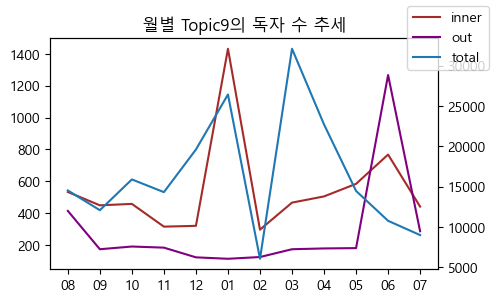

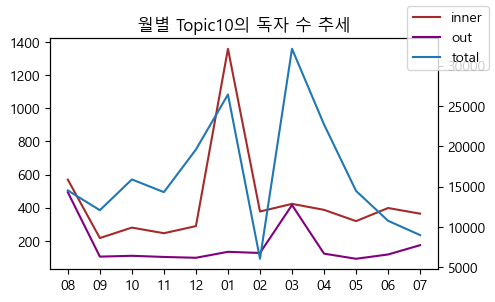

In [83]:
# 월별 토픽별 독자 수 
for propTopic in sorted(innerOuter_origin['propTopic'].unique().tolist()):
    tmp = innerOuter_origin.loc[innerOuter_origin['propTopic'] == propTopic]
    tmp = tmp.groupby(['User Type']).resample('1M')['New IP'].nunique().reset_index()

    fig, ax = plt.subplots(figsize = (5, 3))
    ax.plot(tmp.loc[(tmp['User Type'] == '내부'), 'Timestamp'].astype(str).str[5:7], tmp.loc[(tmp['User Type'] == '내부'), 'New IP'], color = 'brown', label = 'inner')
    ax.plot(tmp.loc[(tmp['User Type'] == '외부'), 'Timestamp'].astype(str).str[5:7], tmp.loc[(tmp['User Type'] == '외부'), 'New IP'], color = 'purple', label = 'out')
       
    ax_twin = ax.twinx()
    tmp_total = innerOuter_origin.resample('1M')['New IP'].count().reset_index()
    ax_twin.plot(tmp.loc[(tmp['User Type'] == '내부'), 'Timestamp'].astype(str).str[5:7], tmp_total['New IP'], label = 'total')
    ax.set_title(f'월별 Topic{int(propTopic) + 1}의 독자 수 추세')
    fig.legend()
    fig.savefig(f'../Result/Graph/PainPoint/readerNum_{int(propTopic) + 1}.png')
    


In [33]:
df_origin['summary_tags'] = df_origin['summary_tags'].apply(lambda x : eval(x))
df_origin['keywords_tags'] = df_origin['keywords_tags'].apply(lambda x : eval(x))
df_origin['totalKeywords'] = df_origin['summary_tags'] + df_origin['keywords_tags']

In [42]:
df_origin['propTopic'].unique()

array(['8', '7', '1', '9', '5', '0', '4', '2', '6', '3'], dtype=object)

In [55]:
df_origin.loc[(df_origin['propTopic'] == '0') & (df_origin['totalKeywords'].apply(lambda x : '투입' in x))]['title'].reset_index()

,date,title
0,2020-06-25,(구)진주역 복합문화공원 설계공모 Studio201 컨소 ‘진주백년공원’ 당선
1,2021-07-02,제주월드컵경기장 내 실내정원 조성한다
2,2021-02-17,"서울시, 예산 10배 늘려 ‘스마트가든’ 44개소 조성 계획"
3,2021-12-15,"한국교원대학교 11,000여 본 규모의 실내정원 조성"
4,2021-04-20,"서울시, ‘녹색 통학로’ 올해 4개소 조성"
5,2020-02-28,"춘천시, 고인돌 테마공원 조성한다···약 15억 투입"
6,2020-12-04,"익산시, 살아 숨쉬는 '수직정원' 설치"
7,2020-02-07,관악구 그린커튼 설치사업 실시


In [102]:
df_origin.loc[(df_origin['propTopic'] == '8') & (df_origin['totalKeywords'].apply(lambda x : '명실' in x))]['title'].reset_index()

,date,title


In [129]:
df_origin.loc[(df_origin['propTopic'] == '2') & (df_origin['totalKeywords'].apply(lambda x : '장관' in x))]['title'].reset_index().head(20)

,date,title
0,2020-08-11,"학교에서 배우는 농업, ‘도시농업관리사’가 함께 한다"


In [124]:
df_origin.loc[(df_origin['propTopic'] == '2'), 'title'].reset_index().iloc[5: 25]

,date,title
5,2023-05-19,"[경관일기] 작은 요새이자 석유부국, 쿠웨이트"
6,2021-11-23,[신간] 궁금하세요? 우리 절집
7,2021-03-16,"광주시, 노지 재배 벗어난 최신 컨테이너 양묘장 구축"
8,2021-02-05,"홀몸어르신 대상 원예치료, 심리 치유 효과 확인"
9,2022-12-09,[경관일기] 바트이슐의 Kaiser Park과 Sissi Park
10,2023-02-14,"식물 이야기부터 직업 세계까지, 수준별 생물다양성 교육 실시"
11,2022-02-25,"월송나무병원, NCS 기반 직무분석표 개발 및 활용"
12,2021-02-21,물향기수목원 설악산 고산지역 희귀식물 전시
13,2020-08-25,"성북구, 24일부터 '텃밭에서 놀다가' 운영"
14,2020-03-12,코로나19에 조경기사·문화재수리기술자·나무의사 시험 연기


In [143]:
df_origin.loc[(df_origin['propTopic'] == '9') & (df_origin['totalKeywords'].apply(lambda x : '야생' in x))]['title'].reset_index().head(20)

,date,title
0,2020-12-17,멸종위기종 맹꽁이 행동특성 밝혀져···대체서식지 조성시 활용
1,2022-06-13,"수원특례시, 대한민국 ‘환경수도’로 도약"
2,2020-10-29,지난해 가구수입 야생화재배업 증가·조경수재배업 감소
3,2020-09-01,주목 등 국제적 멸종위기종 양도·양수 의무 면제 종 확대
4,2023-05-17,"고속도로 로드킬, 2015년 대비 절반 이상 줄어···생태통로 덕"
5,2023-06-23,"서울시, 조류 충돌 방지 건축설계 지침 제작"


In [3]:
df_origin.loc[(df_origin['propTopic'] == '8')]['title'].sample(20).reset_index()

,date,title
0,2021-05-28,2023순천만국제정원박람회 시민참여 아이디어 공모
1,2023-05-09,“민간정원으로 정원여행 떠나볼까?”
2,2020-12-06,(재)순천만국제정원박람회 조직위원회 창립총회 개최
3,2020-10-07,"블루메미술관, ‘재료의 의지?정원에서의 대화’ 전시"
4,2020-09-22,이노블록 ‘사진 & 시공현장 콘테스트’ 개최
5,2021-12-02,"한국기술사회, 기술사회 발전 위한 아이디어 공모전 개최"
6,2020-09-03,"포스트코로나 아이디어 공모전, ‘비대면 공원’ 당선"
7,2021-01-12,"경기도농수산진흥원, '먹거리 소통 광장 조성' 설계 공모"
8,2021-09-15,"은폐된 죽음, 정원에서 기억하다…‘The Sun is Going Home’ 展"
9,2020-09-17,‘제8회 경기정원문화박람회’ 내년 봄으로 연기


In [4]:
# 토픽별 최다 조회 뉴스
innerOuter_origin.head(2)

,IP,URL,URL Search Word,Referer,Referer Search Word,Referer Source,Referer Category,New IP,User Type,month,day,hour,bigPath,middlePath,smallPath,tmp,news_id,propTopic
Timestamp,,,,,,,,,,,,,,,,,,
2023-07-11 03:13:45+09:00,110.93.154.209,/inews/news_view_print.html?news_id=132561#,NaN,NaN,NaN,NaN,etc,1000200,내부,7,11,3,뉴스,뉴스홈,뉴스홈,inews,132561,2
2023-07-11 03:15:50+09:00,110.93.154.209,/inews/news_view_print.html?news_id=132557#,NaN,NaN,NaN,NaN,etc,1000200,내부,7,11,3,뉴스,뉴스홈,뉴스홈,inews,132557,6


In [14]:
df_origin.head(2)

,title,sub-title,publisher,author,text,keywords,href,numKeywords,news_id,year,...,summary,summary_tags,title_tags,subtitle_tags,keywords_tags,numTopic,propTopic,propTopicRatio,topicsRatio,totalKeywords
date,,,,,,,,,,,,,,,,,,,,,
2022-11-07,2022년 올해의 정원식물은?,‘2022 대한민국 정원식물 전시·품평회’ 성료,라펜트,전지은,‘2022 대한민국 정원식물 전시·품평회’를? 9월 30일부터 10월 30일까지 개...,"['한국수목원정원관리원', '대한민국 정원식물 전시·품평회', '정원식물']",https://www.lafent.com/inews/news_view.html?ne...,3,131470,2022.0,...,한국수목원정원관리원은 가을 정취를 느낄 수 있는 FW 시즌 정원식물 788품종을 한...,"[한국, 수목원, 정원, 관리원, 가을, 정취, 느끼다, 있다, 시즌, 정원, 식물...","['올해', '정원', '식물']","['대한민국', '정원', '식물', '전시', '품평회', '성']","[한국, 수목원, 정원, 관리원, 대한민국, 정원, 식물, 전시, 품평회, 정원, 식물]",10,8,0.7010,"[(0, 0.12626038), (4, 0.07635856), (5, 0.08301...","[한국, 수목원, 정원, 관리원, 가을, 정취, 느끼다, 있다, 시즌, 정원, 식물..."
2020-01-17,‘골목길’ 주제 도시재생세미나 30일 개최,김선아 대표·김영욱 교수 주제발표,한국건설신문,선태규,한국건축가협회 도시재생위원회위원장 김선아는 오는 30일 오후 6시 30분부터 8시 ...,"['한국건축가협회', '도시재생위원회', '도시재생', '골목길']",https://www.lafent.com/inews/news_view.html?ne...,4,125638,2020.0,...,한국건축가협회 도시재생위원회위원장 김선아는 오는 30일 오후 6시 30분부터 8시 ...,"[한국, 건축가, 협회, 도시, 재생, 위원회, 위원장, 김, 선아, 오다, 오후,...","['골목길', '주제', '도시', '재생', '세미나', '개최']","['김', '선아', '대표', '김', '영', '교수', '주제', '발표']","[한국, 건축가, 협회, 도시, 재생, 위원회, 도시, 재생, 골목길]",10,7,0.4431,"[(3, 0.23829404), (7, 0.44309682), (9, 0.30562...","[한국, 건축가, 협회, 도시, 재생, 위원회, 위원장, 김, 선아, 오다, 오후,..."


In [17]:
tmp = innerOuter_origin.groupby(['propTopic', 'news_id', 'User Type'])['IP'].count().reset_index()
tmp = tmp.groupby(['propTopic', 'User Type']).apply(lambda x : x.sort_values(by = ['IP'], ascending = False).iloc[:3]).reset_index(drop = True)
tmp = tmp.merge(df_origin[['news_id', 'title']], on = 'news_id', how = 'left').drop(columns = ['news_id'])

In [18]:
tmp

,propTopic,User Type,IP,title
0,0,내부,666,[당선작] 청주 360
1,0,내부,240,라펜트가 선정한 2022년 조경계 10대뉴스 - 해외편
2,0,내부,237,“진해 군항제 벚나무는 일본산 소메이요시노벚나무 일색”
3,0,외부,2279,[당선작] 청주 360
4,0,외부,116,"삼성물산, 롯데월드타워 ‘베르테르의 정원’ 조성···‘인기만발!’"
5,0,외부,113,“정원은 공간에 새로운 가치를 부여하는 일”
6,1,내부,586,평택역 광장 국제설계공모 당선작 발표
7,1,내부,378,"용인시, 유방동에 8천㎡ 규모 도시숲 조성"
8,1,내부,369,"인천 6대 하천, 제2의 청계천으로 변모"
9,1,외부,2302,평택역 광장 국제설계공모 당선작 발표
